In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
from numpy import dot, array
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [4]:
def getKernelizedProductforPrediction(X_data,val_X_data,IntermXmatrix,currentValIndex,num_classes,kernel,sigma):
    X = X_data
    m = (X_data.shape[0]*(num_classes-1))
    H = np.zeros((m,num_classes))    
    matrix2 = (currentValIndex+1)*np.eye(num_classes)
               
    if(kernel == 'rbf'): 
        for i in (range(0,m)):
            for j in range(0,num_classes):
                count1 = 0
                for k in range(0,num_classes):
                    if(count1==2):
                        break
                    else:
                        temp3 = int(IntermXmatrix[i,k])
                        temp4 = int(matrix2[k,j])
                        if(temp3>0):
                            count1+=1
                            if(temp4>0):                             
                                H[i,j] += np.exp(-1*(np.linalg.norm(X[temp3-1,:]-val_X_data[temp4-1,:]))/(2*sigma**2))                        
                        elif(temp3<0):
                            count1+=1
                            if(temp4>0):
                                H[i,j] += np.exp(-1*(np.linalg.norm(np.append(val_X_data[temp4-1,:],1.0)-np.append(-1*X[-temp3-1,:],-1.0)))/(2*sigma**2))                    
                                                           
    return H      

In [5]:
def getKernelizedProduct(X_data,Y_label,kernel,sigma):
    X = X_data
    trainLabelVector = Y_label
    num_classes = len(np.unique(Y_label))
    IntermXmatrix = np.zeros(((X_data.shape[0]*(num_classes-1)),num_classes))
    count6 = 0
    for i in tqdm(range(0,X.shape[0])):
        for p in range(0,num_classes):
            if(trainLabelVector[i]!=p):   
                for j in range(0,num_classes):
                    if(j==trainLabelVector[i]):
                        IntermXmatrix[count6,j] = i+1
                    elif(j==p):
                        IntermXmatrix[count6,j] = -(i+1)
                count6 += 1
                
    matrix2 = IntermXmatrix.T
    M2 = scipy.sparse.coo_matrix(IntermXmatrix)
    M3 = scipy.sparse.coo_matrix(IntermXmatrix.T)
    m = (X_data.shape[0]*(num_classes-1))
    H = np.zeros((m,m)) 
    
    if(kernel == 'rbf'):
        for i in tqdm(range(0,m)):
            for j in range(0,i+1):
                count1 = 0
                #count2 = 0
                for k in range(0,IntermXmatrix.shape[1]):
                    if(count1==2):
                        break
                    else:
                        temp3 = int(IntermXmatrix[i,k])
                        temp4 = int(matrix2[k,j])
                        #print(temp3,temp4)
                        if(temp3>0):
                            count1+=1
                            if(temp4>0):                             
                                H[i,j] += np.exp(-1*(np.linalg.norm(X[temp3-1,:]-X[temp4-1,:]))/(2*sigma**2))
                            elif(temp4<0):
                                H[i,j] += np.exp(-1*(np.linalg.norm(np.append(X[temp3-1,:],1.0)-np.append(-1*X[-temp4-1,:],-1.0)))/(2*sigma**2))
                        elif(temp3<0):
                            count1+=1
                            if(temp4>0):
                                H[i,j] += np.exp(-1*(np.linalg.norm(np.append(X[temp4-1,:],1.0)-np.append(-1*X[-temp3-1,:],-1.0)))/(2*sigma**2))                    
                            elif(temp4<0):
                                H[i,j] += np.exp(-1*(np.linalg.norm(-1*X[-temp3-1,:]+X[-temp4-1,:]))/(2*sigma**2))

    for i in tqdm(range(0,m)):
        for j in range(0,i+1):
            if(j>i):
                H[i,j]=H[j,i]                 
    #print(H.shape)        
    
    return H,IntermXmatrix

In [6]:
def Build_SVM_Classifier1(X_data,Y_label,C=10,kernel = 'linear',degree = 2,sigma = 0.25):      
    X = X_data
    trainLabelVector = Y_label
    #fullXmatrix =[]
    num_classes = len(np.unique(Y_label))
    print(trainLabelVector.shape)
    
    fullXmatrix = np.zeros(((X_data.shape[0]*(num_classes-1)),num_classes*((X_data.shape[1])+1)))
    
    #for i in tqdm(range(0,(X_data.shape[0]*(num_class-1)))):
    
    count5 = 0
    for i in tqdm(range(0,X.shape[0])):
        for p in range(0,num_classes):
            if(trainLabelVector[i]!=p):   
                for j in range(0,num_classes):
                    if(j==trainLabelVector[i]):
                        fullXmatrix[count5,(j*(X_data.shape[1]+1)):((j+1)*(X_data.shape[1]+1))-1] = X[i,:]
                        fullXmatrix[count5,((j+1)*(X_data.shape[1]+1))-1] = 1.0
                    elif(j==p):
                        fullXmatrix[count5,(j*(X_data.shape[1]+1)):((j+1)*(X_data.shape[1]+1))-1] = -1*X[i,:]
                        fullXmatrix[count5,((j+1)*(X_data.shape[1]+1))-1] = -1.0
                count5 += 1
                #print(count5)
    print(fullXmatrix.shape)
    m = fullXmatrix.shape[0]
    M1 = sparse.csr_matrix(fullXmatrix) 
    IntermXmatrix = np.zeros(((X_data.shape[0]*(num_classes-1)),num_classes))
    if(kernel=='polynomial'):   
        H = sparse.csr_matrix.dot(M1,M1.T) 
        H = (1+H.todense())**degree   
    elif(kernel=='linear'):
        H = sparse.csr_matrix.dot(M1,M1.T)
    else:
        H,IntermXmatrix = getKernelizedProduct(X_data,Y_label,kernel,sigma)        
        
    from cvxopt import matrix as cvxopt_matrix
    from cvxopt import solvers as cvxopt_solvers
    if(kernel=='linear'):
        P = cvxopt_matrix(H.todense())
    else:
        P = cvxopt_matrix(H)
    q = cvxopt_matrix(-1*np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    opts = {'maxiters' : 30,'solver':'mosek'}
    sol = cvxopt_solvers.qp(P, q, G, h ,options = opts)
    alphas2 = np.array(sol['x']) 
    #w = fullXmatrix.T@alphas2
    #wForEachLabel = {}
    #for i in range(0,num_classes):
        #wForEachLabel[i] = np.array_split(w,num_classes)[i]
        
    return alphas2,fullXmatrix,IntermXmatrix
    #return wForEachLabel

In [14]:
def plot_decision_regions(X, y,resolution=1, test_idx=None):
   # setup marker generator and color map
   markers = ('s', 'x', 'o', '^', 'v')
   colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
   cmap = ListedColormap(colors[:len(np.unique(y))])

   # plot the decision surface
   x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
   x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
   xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
   np.arange(x2_min, x2_max, resolution))
    #alphas2,fullXmatrix,IntermXmatrix = Build_SVM_Classifier1(train_X_data,train_Y_data,C,kernel,degree,sigma)
   Z = predict(train_X_data,np.array([xx1.ravel(), xx2.ravel()]).T,IntermXmatrix,num_classes,alphas2,fullXmatrix,kernel,degree,sigma)
   #Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
   Z = np.array(Z) 
   Z = Z.reshape(xx1.shape)
   plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
   plt.xlim(xx1.min(), xx1.max())
   plt.ylim(xx2.min(), xx2.max())

   # plot all samples
   X_test, y_test = X[test_idx, :], y[test_idx]
   for idx, cl in enumerate(np.unique(y)):
      plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
               alpha=0.8, c=cmap(idx),
               marker=markers[idx], label=cl)
   # highlight test samples
   if test_idx:
      X_test, y_test = X[test_idx, :], y[test_idx]
      plt.scatter(X_test[:, 0], X_test[:, 1], c='',
               alpha=1.0, linewidth=1, marker='o',
               s=55, label='test set')

In [7]:
def predict(train_X_data,val_X_data,IntermXmatrix,num_classes,alphas2,fullXmatrix,kernel,degree,sigma):
    predictedLabelVector = []
    if(kernel == 'linear'):
        w = fullXmatrix.T@alphas2
        wForEachLabel = {}
        for i in range(0,num_classes):
            wForEachLabel[i] = np.array_split(w,num_classes)[i]
        for i in tqdm(range(0,val_X_data.shape[0])):
            scoresForEachLabel = []
            for j in range(0,len(wForEachLabel)):
                score = (wForEachLabel[j].T@np.append(val_X_data[i,:],1.0).reshape(-1,1))
                scoresForEachLabel.append(score)
            maxScoreLabel = np.argmax(scoresForEachLabel)
            predictedLabelVector.append(maxScoreLabel)
    elif(kernel == 'polynomial'):
        for i in tqdm(range(0,val_X_data.shape[0])):
            tempMatrix1 = np.zeros((num_classes*(val_X_data.shape[1]+1),num_classes))
            for j in range(0,num_classes):
                tempMatrix1[j*(val_X_data.shape[1]+1):(j+1)*(val_X_data.shape[1]+1),j] = np.append(val_X_data[i,:],1.0)
            scoresForEachLabel = (alphas2.T)@((1+(fullXmatrix@tempMatrix1))**degree)
            maxScoreLabel = np.argmax(scoresForEachLabel)
            predictedLabelVector.append(maxScoreLabel)
    elif(kernel == 'rbf'):
        for i in tqdm(range(0,val_X_data.shape[0])):
            #tempMatrix1 = np.zeros((num_classes*(val_X_data.shape[1]+1),num_classes))
            #for j in range(0,num_classes):
                #tempMatrix1[j*(val_X_data.shape[1]+1):(j+1)*(val_X_data.shape[1]+1),j] = np.append(val_X_data[i,:],1.0)
            scoresForEachLabel = (alphas2.T)@((1+(getKernelizedProductforPrediction(train_X_data,val_X_data,IntermXmatrix,i,num_classes,kernel,sigma)))**degree)
            maxScoreLabel = np.argmax(scoresForEachLabel)
            predictedLabelVector.append(maxScoreLabel)
    return predictedLabelVector

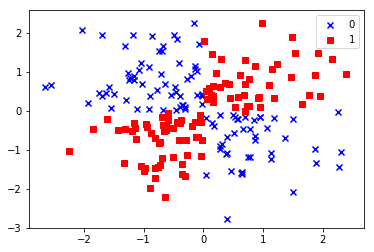

In [9]:
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 0, 1)
plt.scatter(X_xor[y_xor==0, 0], X_xor[y_xor==0, 1], c='b', marker='x', label='0')
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='r', marker='s', label='1')
plt.ylim(-3.0)
plt.legend()
plt.show()

In [11]:
ran = np.random.rand(len(X_xor)) < 0.8
train_X_data = X_xor[ran]
train_Y_data = y_xor[ran]
val_X_data = X_xor[~ran]
val_Y_data = y_xor[~ran]
num_classes = len(np.unique(train_Y_data))
kernel = 'rbf'
degree = 1
sigma = 0.5
C = 100

In [19]:
alphas2,fullXmatrix,IntermXmatrix = Build_SVM_Classifier1(train_X_data,train_Y_data,C,kernel,degree,sigma)

(162,)


100%|█████████████████████████████████████| 162/162 [00:00<00:00, 54046.87it/s]


(162, 6)


100%|████████████████████████████████████| 162/162 [00:00<00:00, 161895.94it/s]


     pcost       dcost       gap    pres   dres
 0:  3.6146e+04 -1.3013e+05  2e+05  4e-17  3e-14
 1:  6.3059e+03 -9.6449e+03  2e+04  2e-16  4e-14
 2:  8.6434e+02 -1.1075e+03  2e+03  2e-16  2e-14
 3:  1.0456e+02 -1.7938e+02  3e+02  2e-16  7e-15
 4:  5.6347e+00 -3.4024e+01  4e+01  2e-16  2e-15
 5: -4.9458e+00 -9.8300e+00  5e+00  2e-16  8e-16
 6: -5.5634e+00 -5.9202e+00  4e-01  2e-16  2e-16
 7: -5.5876e+00 -5.6332e+00  5e-02  2e-16  2e-16
 8: -5.5917e+00 -5.5970e+00  5e-03  2e-16  2e-16
 9: -5.5923e+00 -5.5932e+00  9e-04  2e-16  2e-16
10: -5.5925e+00 -5.5926e+00  1e-04  2e-16  2e-16
11: -5.5925e+00 -5.5925e+00  1e-05  2e-16  2e-16
12: -5.5925e+00 -5.5925e+00  6e-07  2e-16  2e-16
Optimal solution found.


In [ ]:
#prediction for training data

In [20]:
predictedLabels = predict(train_X_data,train_X_data,IntermXmatrix,num_classes,alphas2,fullXmatrix,kernel,degree,sigma)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),train_Y_data.reshape(-1,1).ravel())
conMatrix

100%|███████████████████████████████████████| 162/162 [00:01<00:00, 135.53it/s]


col_0,0,1
row_0,,
0,84,0
1,0,78


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 130.15it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


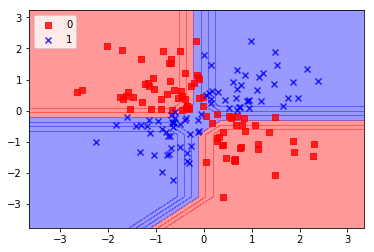

In [21]:
plot_decision_regions(train_X_data, train_Y_data, resolution=1)
plt.legend(loc='upper left')
plt.show()

In [ ]:
#prediction for validation data

In [22]:
predictedLabels = predict(train_X_data,val_X_data,IntermXmatrix,num_classes,alphas2,fullXmatrix,kernel,degree,sigma)
conMatrix = pd.crosstab(np.array(predictedLabels).ravel(),val_Y_data.reshape(-1,1).ravel())
conMatrix

100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 133.40it/s]


col_0,0,1
row_0,,
0,15,0
1,2,21


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 114.82it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


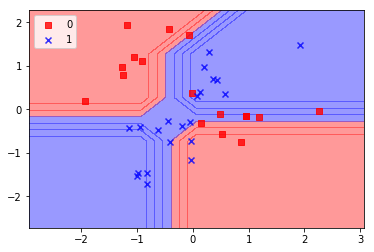

In [23]:
plot_decision_regions(val_X_data, val_Y_data, resolution=1)
plt.legend(loc='upper left')
plt.show()